#### 7/14/25 - Past Month Weather Data and Map Creation     
By: Angel Moreno

In [148]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import requests
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import glob

#### Getting the weather data:

Using https://open-meteo.com/en/docs?past_days=31 api endpoint.

In [149]:
# tracts = gpd.read_file("Tiger_Illinois_Tracts_2020.zip")  

chicago_tracts = gpd.read_file("Chicago_Tracts_2020.zip")
chicago_tracts_proj = chicago_tracts.to_crs("EPSG:26916")

chicago_tracts_proj['centroid'] = chicago_tracts_proj.geometry.centroid
centroids_geo = chicago_tracts_proj['centroid'].to_crs(epsg=4326)

chicago_tracts['latitude'] = centroids_geo.y
chicago_tracts['longitude'] = centroids_geo.x

chicago_tracts.shape

(878, 21)

Before moving forward to the api calls I need to double check the data types (this was giving me trouble).

In [150]:
chicago_tracts.dtypes

objectid             float64
census_tra            object
census_t_1            object
tract_fips            object
tract_cent           float64
tract_ce_1           float64
tract_ce_2           float64
tract_ce_3           float64
tract_comm            object
tract_numa           float64
tract_cens           float64
perimeter            float64
data_admin           float64
tract_crea            object
date_tract    datetime64[ms]
time_tract            object
shape_area           float64
shape_len            float64
geometry            geometry
latitude             float64
longitude            float64
dtype: object

In [151]:
chicago_tracts.rename(columns={"census_t_1":"tract_id"}, inplace=True)
chicago_tracts["tract_id"] = chicago_tracts["tract_id"].astype(np.int64)

In [152]:
chicago_tracts.dtypes

objectid             float64
census_tra            object
tract_id               int64
tract_fips            object
tract_cent           float64
tract_ce_1           float64
tract_ce_2           float64
tract_ce_3           float64
tract_comm            object
tract_numa           float64
tract_cens           float64
perimeter            float64
data_admin           float64
tract_crea            object
date_tract    datetime64[ms]
time_tract            object
shape_area           float64
shape_len            float64
geometry            geometry
latitude             float64
longitude            float64
dtype: object

In [153]:
chicago_tracts.isna().sum()

objectid        0
census_tra      0
tract_id        0
tract_fips      0
tract_cent      0
tract_ce_1      0
tract_ce_2      0
tract_ce_3      0
tract_comm      0
tract_numa      0
tract_cens      0
perimeter       0
data_admin      0
tract_crea    878
date_tract    878
time_tract    878
shape_area      0
shape_len       0
geometry        0
latitude        0
longitude       0
dtype: int64

In [154]:
outside_bounds = chicago_tracts[
    (chicago_tracts["latitude"] < 41.5) | 
    (chicago_tracts["latitude"] > 42.1) | 
    (chicago_tracts["longitude"] > -87.5) | 
    (chicago_tracts["longitude"] < -88.1)
]
print(f"Outside Chicago bounds: {len(outside_bounds)}")


Outside Chicago bounds: 0


In [155]:
chicago_tracts.shape

(878, 21)

In [ ]:
# for testing
# chicago_tracts = chicago_tracts.sample(10)
# chicago_tracts.tract_id.nunique()

100

In [122]:
def fetch_tract_weather(row, save_dir="weather_data"):
    '''Script to get past month weather data for each tract in Chicago as per the 2020 Census data. \nReturns a dataframe. '''
    
    lat = row["latitude"]
    lon = row["longitude"]
    
    tract_id = row["tract_id"] # this is the tract identifier
    filename = os.path.join(save_dir, f"tract_weather_{tract_id}.parquet") # caching

    if os.path.exists(filename):
        try:
            return pd.read_parquet(filename)
        except Exception as e:
            print(f"Failed to read existing data for tract {tract_id}: {e}")

    api_params = {
        "latitude": lat,
        "longitude": lon,
        "hourly": ["temperature_180m", "wind_direction_180m", "wind_speed_180m", "surface_pressure", "cloud_cover", "relative_humidity_2m", "precipitation", "visibility"],
        "timezone": "America/Chicago",
        "past_days": 1, # just 1 day right now for testing
        "forecast_days": 0,
        "wind_speed_unit": "mph",
        "temperature_unit": "fahrenheit",
        "precipitation_unit": "inch"
    }

    api = "https://api.open-meteo.com/v1/forecast"  

    try:
        time.sleep(0.1)
        response = requests.get(api, params=api_params, timeout=15)
        response.raise_for_status()
        data = response.json()

        if "hourly" not in data:
            raise ValueError(f"No 'hourly' key found: {data}")

        hourly_data = pd.DataFrame(data["hourly"])
        hourly_data["tract_id"] = tract_id

        os.makedirs(save_dir, exist_ok=True)
        hourly_data.to_parquet(filename, index=False)

        return hourly_data

    except Exception as e:
        print(f"Failed for tract {row['tract_id']} at ({lat}, {lon}): {e}")
        return None

In [ ]:
def all_tracts_weather():
    '''Get past month weather data for each Chicago tract (2020).'''
    final_csv_data = []

    with ThreadPoolExecutor(max_workers=3) as executor:
        futures = [executor.submit(fetch_tract_weather, row) for _, row in chicago_tracts.iterrows()]
        
        # tdqm progress bar 
        for future in tqdm(as_completed(futures), total=len(futures), desc="Fetching weather data"):
            result = future.result()
            if result is not None:
                final_csv_data.append(result)

    all_tracts_csv = pd.concat(final_csv_data, ignore_index=True)
    return all_tracts_csv

3-5 minute expected runtime for the full 30 day data

In [124]:
final_tracts_weather_csv = all_tracts_weather()
final_tracts_weather_csv

Fetching weather data: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]

Failed for tract 17031720500 at (41.70283387396023, -87.68910703380652): 429 Client Error: Too Many Requests for url: https://api.open-meteo.com/v1/forecast?latitude=41.70283387396023&longitude=-87.68910703380652&hourly=temperature_180m&hourly=wind_direction_180m&hourly=wind_speed_180m&hourly=surface_pressure&hourly=cloud_cover&hourly=relative_humidity_2m&hourly=precipitation&hourly=visibility&timezone=America%2FChicago&past_days=1&forecast_days=0&wind_speed_unit=mph&temperature_unit=fahrenheit&precipitation_unit=inch
Failed for tract 17031730200 at (41.72663577718923, -87.65353788921948): 429 Client Error: Too Many Requests for url: https://api.open-meteo.com/v1/forecast?latitude=41.72663577718923&longitude=-87.65353788921948&hourly=temperature_180m&hourly=wind_direction_180m&hourly=wind_speed_180m&hourly=surface_pressure&hourly=cloud_cover&hourly=relative_humidity_2m&hourly=precipitation&hourly=visibility&timezone=America%2FChicago&past_days=1&forecast_days=0&wind_speed_unit=mph&temp

ValueError: No objects to concatenate

In [108]:
all_files = glob.glob("weather_data/tract_weather_*.parquet")
full_df = pd.concat([pd.read_parquet(f) for f in all_files], ignore_index=True)

NameError: name 'glob' is not defined

In [89]:
expected_rows_1d = (878 * 24 * 1) # rows * hours * days
expected_rows_1d

21072

In [90]:
num_unique_tracts = final_tracts_weather_csv['tract_id'].nunique()
print(f"Number of tracts with data: {num_unique_tracts}")

Number of tracts with data: 352


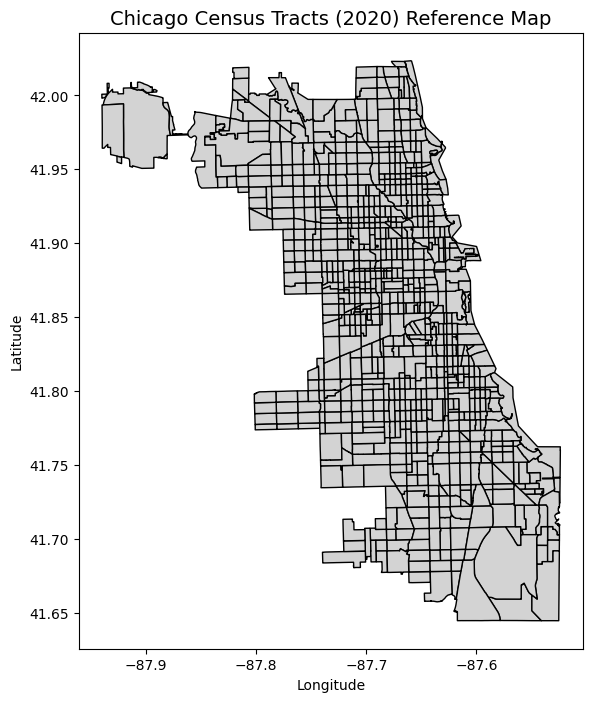

In [91]:
fig, ax = plt.subplots(figsize=(8, 8))
chicago_tracts.plot(ax=ax, edgecolor='black', facecolor='lightgray')
ax.set_title("Chicago Census Tracts (2020) Reference Map", fontsize=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

#### Cleaning/preparing the data:

In [92]:
final_tracts_weather_csv["trimmed_time"] = final_tracts_weather_csv["time"].str.slice(0,10)
final_tracts_weather_csv["cleaned_time"] = pd.to_datetime(final_tracts_weather_csv["trimmed_time"])

agg_weather_data = final_tracts_weather_csv.drop(columns=["time","trimmed_time"]).groupby(["cleaned_time","tract_id"]).agg("mean").reset_index()
agg_weather_data

,cleaned_time,tract_id,temperature_180m,wind_direction_180m,wind_speed_180m,surface_pressure,cloud_cover,relative_humidity_2m,precipitation,visibility
0,2025-06-14,17031000000,61.441667,57.958333,12.975000,995.554167,76.250000,90.833333,0.0,43744.532000
1,2025-06-14,17031010100,61.866667,60.208333,12.941667,994.437500,76.458333,85.583333,0.0,42145.122417
2,2025-06-14,17031010200,61.866667,60.208333,12.941667,994.437500,76.458333,85.583333,0.0,42145.122417
3,2025-06-14,17031010500,61.879167,60.208333,12.941667,994.554167,76.458333,85.583333,0.0,42145.122417
4,2025-06-14,17031010600,61.879167,60.208333,12.941667,994.658333,76.458333,85.583333,0.0,42145.122417
...,...,...,...,...,...,...,...,...,...,...
10555,2025-07-13,17031808100,71.920833,291.958333,10.291667,993.150000,45.958333,66.625000,0.0,90619.532500
10556,2025-07-13,17031810501,71.887500,291.958333,10.291667,992.133333,50.833333,66.416667,0.0,92547.025375
10557,2025-07-13,17031811600,71.933333,291.958333,10.291667,992.612500,46.125000,65.166667,0.0,94857.284750
10558,2025-07-13,17031821500,72.770833,294.666667,9.629167,994.704167,42.541667,66.083333,0.0,92328.302833


#### Creating the maps:

This map creation will include ~866 tracts since it is using 2020 census data.

In [93]:
## merge weather data with chicago_tracts and keep only relevant columns
df_merged = agg_weather_data.merge(chicago_tracts, on="tract_id", how="inner")
df_merged.shape

(10560, 30)

In [94]:
df_merged = df_merged[['cleaned_time','tract_id', 'cloud_cover', 'visibility',
       'relative_humidity_2m', 'precipitation', 'wind_speed_180m',
       'wind_direction_180m', 'temperature_180m', 'surface_pressure','geometry']]
gdf = gpd.GeoDataFrame(df_merged, geometry="geometry")
print(type(gdf))
print(gdf.crs) # 4326 is the world crs with lat and lon 

<class 'geopandas.geodataframe.GeoDataFrame'>
EPSG:4326


In [95]:
gdf = gdf.to_crs("EPSG:26916")
gdf = gdf[gdf.area != gdf.area.max()]
gdf = gdf.to_crs("EPSG:4326")

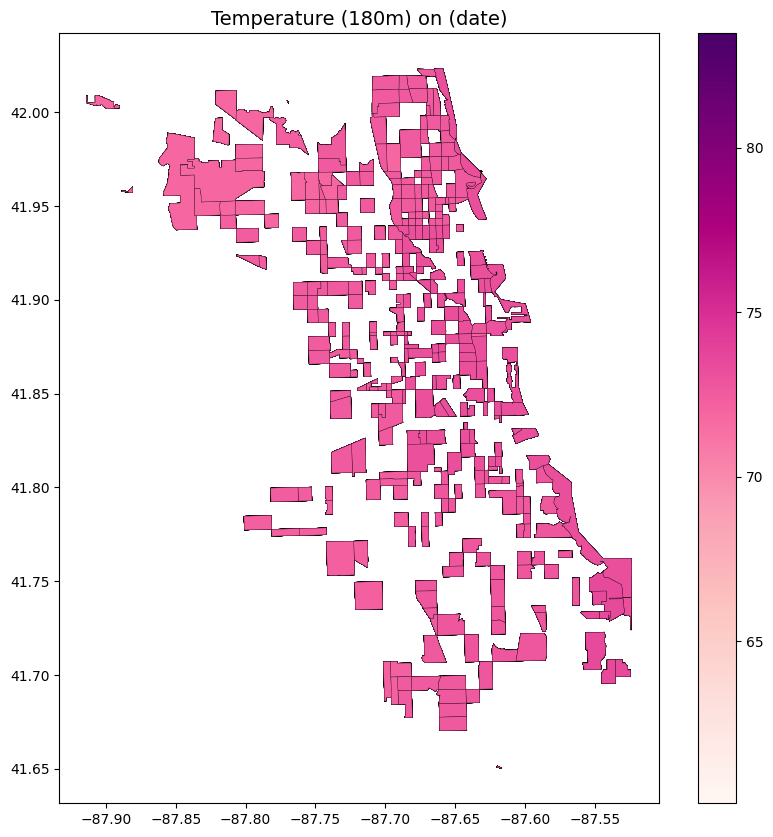

In [96]:
fig, ax = plt.subplots(figsize=(10, 10))

gdf.plot(
    column="temperature_180m",
    cmap="RdPu",
    legend=True,
    ax=ax,
    edgecolor="black",
    linewidth=0.2
)

ax.set_title("Temperature (180m) on (date)", fontsize=14)
plt.show()

#### Putting it all together (run once and see results)

In [ ]:
# click run all at top